In [1]:
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx
import community as community_louvain
from sklearn.metrics.pairwise import cosine_similarity
import tqdm

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Get the entire vocabulary
all_tokens = list(tokenizer.vocab.keys())
word_embeddings = model.embeddings.word_embeddings.weight.detach().numpy()
random_indices=np.random.randint(0,len(all_tokens),10000)

subset_tokens=[all_tokens[i] for i in random_indices]
subset_embeddings=word_embeddings[random_indices]


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Aglomerative clustering

In [ ]:



# Apply agglomerative clustering
cluster_agglomerative = AgglomerativeClustering(affinity='euclidean',n_clusters=100 ,linkage='ward')
cluster_agglomerative.fit(word_embeddings)


In [ ]:

# Plot the dendrogram
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(20, 10))
plot_dendrogram(cluster, labels=subset_tokens, leaf_rotation=90.)
plt.show()



In [ ]:

labels = cluster_agglomerative.fit_predict(word_embeddings)
n_clusters_desired=100
# Create a word cloud for each cluster
for cluster_id in range(n_clusters_desired):
    words_in_cluster = [all_tokens[i] for i, label in enumerate(labels) if label == cluster_id]
    wordcloud_text = ' '.join(words_in_cluster)

    # Generate the word cloud
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate(wordcloud_text)

    # Display the word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster_id}')
    plt.show()

## Partitioing methods

In [ ]:


# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Get the entire vocabulary and embeddings
all_tokens = list(tokenizer.vocab.keys())
word_embeddings = model.embeddings.word_embeddings.weight.detach().numpy()

# Apply K-means clustering
n_clusters_desired = 100
kmeans = KMeans(n_clusters=n_clusters_desired, random_state=0)
labels_kmeans = kmeans.fit_predict(word_embeddings)





In [ ]:

# Create a word cloud for each cluster
for cluster_id in range(n_clusters_desired):
    words_in_cluster = [all_tokens[i] for i, label in enumerate(labels) if label == cluster_id]
    if len(words_in_cluster) == 0:
        print(f"No words in community {cluster_id}, skipping...")
        continue
    wordcloud_text = ' '.join(words_in_cluster)

    # Generate the word cloud
    wordcloud = WordCloud(background_color='white', width=800, height=400).generate(wordcloud_text)

    # Display the word cloud
    plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Cluster {cluster_id}')
    plt.show()

## Graph based methods

In [ ]:

from collections import OrderedDict
random_indices=np.random.randint(0,len(all_tokens),10000)

subset_tokens=[all_tokens[i] for i in random_indices]
subset_embeddings=word_embeddings[random_indices]
similarity_matrix = cosine_similarity(subset_embeddings)

G = nx.Graph()

# Add edges to the graph (you can introduce a threshold to limit edges)
#threshold = 0.65
threshold = 0.5

rows, cols = np.where(similarity_matrix > threshold)
weights = similarity_matrix[rows, cols]

edges = zip(rows, cols, weights)

for i, j, weight in edges:
    if i < j:
        G.add_edge(subset_tokens[i], subset_tokens[j], weight=weight)
# Apply the Louvain method
partition = community_louvain.best_partition(G,resolution=0.2)

# Create a word cloud for each community (cluster)
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)




# Sort communities by the number of nodes they contain
sorted_communities = OrderedDict(sorted(communities.items(), key=lambda x: len(x[1]), reverse=True))



In [ ]:

for community_id, words_in_community in list(sorted_communities.items())[:50]:
    if len(words_in_community) == 0:
        print(f"No words in community {community_id}, skipping...")
        continue  # Skip to the next iteration
    else:
        wordcloud_text = ' '.join(words_in_community)
        try:
            wordcloud = WordCloud(background_color='white', width=800, height=400).generate(wordcloud_text)
        except ValueError as e:
            print(f"Error generating word cloud for community {community_id}: {e}")
            continue  # Skip to the next iteration

        # Display the word cloud
        plt.figure()
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Community {community_id}')
        plt.show()


### Find the best threshold and the best resolution to maximize clusterability

In [ ]:
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import community as community_louvain
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Custom metric for evaluating communities
def custom_metric(num_communities, node_counts):
    # Score for even distribution. Could be mean, median, or other statistics.
    evenness_score = np.mean(node_counts)
    return num_communities * evenness_score

# Generate a similarity matrix
random_indices=np.random.randint(0,len(all_tokens),1000)

subset_tokens=[all_tokens[i] for i in random_indices]
subset_embeddings=word_embeddings[random_indices]
similarity_matrix = cosine_similarity(subset_embeddings)

best_metric = -1
best_threshold = None
best_resolution = None
best_partition = None

# Loop through possible thresholds and resolutions
for threshold in tqdm(np.linspace(0.5, 0.9, 10)):  # Adjust as needed
    for resolution in np.linspace(0.2, 1.0, 10):  # Adjust as needed
        G = nx.Graph()

        # Add edges if above threshold
        rows, cols = np.where(similarity_matrix > threshold)
        edges = zip(rows.tolist(), cols.tolist())
        for i, j in edges:
            if i < j:
                G.add_edge(all_tokens[i], all_tokens[j], weight=similarity_matrix[i, j])

        # Find communities
        partition = community_louvain.best_partition(G, resolution=resolution)

        # Count nodes per community
        communities = {}
        for node, community_id in partition.items():
            if community_id not in communities:
                communities[community_id] = []
            communities[community_id].append(node)

        num_communities = len(communities)
        node_counts = [len(nodes) for nodes in communities.values()]

        # Compute the custom metric
        metric = custom_metric(num_communities, node_counts)

        if metric > best_metric:
            best_metric = metric
            best_threshold = threshold
            best_resolution = resolution
            best_partition = partition

print(f"Best custom metric: {best_metric}")
print(f"Best threshold: {best_threshold}")
print(f"Best resolution: {best_resolution}")

# Use best_partition for your subsequent analyses



- Best threshold: 0.65
- Best resolution: 0.7

### Clustering Metrics


**Silhouette score**

In [ ]:
from sklearn.metrics import silhouette_score
import tqdm
random_indices=np.random.randint(0,len(all_tokens),1000)

subset_tokens=[all_tokens[i] for i in random_indices]
subset_embeddings=word_embeddings[random_indices,]
similarity_matrix = cosine_similarity(subset_embeddings)

def compute_silhouette_score(X, labels):
    return silhouette_score(X, labels)
# Apply K-means clustering
silh=list()
n_clusters_desired = [10,30,50,100,200,300,400,500]
for n in tqdm.tqdm(n_clusters_desired):
    kmeans = KMeans(n_clusters=n, random_state=0)
    labels_kmeans = kmeans.fit_predict(subset_embeddings)
    silh.append(compute_silhouette_score(similarity_matrix,kmeans.labels_))

print(silh)


In [ ]:

# Create the figure and set the size
plt.figure(figsize=(12, 6))

# Create the scatter plot
plt.scatter(n_clusters_desired, silh, c='blue', marker='o', edgecolors='black', linewidths=1)

# Add title and labels with font customization
plt.title('Silhouette Score of a Sample (10k) of BERT Embeddings for Different Number of Clusters for KMEANS', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)

# Add grid for better readability of the plot
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Optionally, you can add text annotations or other customizations here

# Show the plot
plt.show()


  0%|          | 0/8 [00:00<?, ?it/s]/home/gerard/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/gerard/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 12%|█▎        | 1/8 [00:00<00:02,  2.71it/s]/home/gerard/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/home/gerard/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
 25%|██▌       | 2/8 [00:00<00:02,

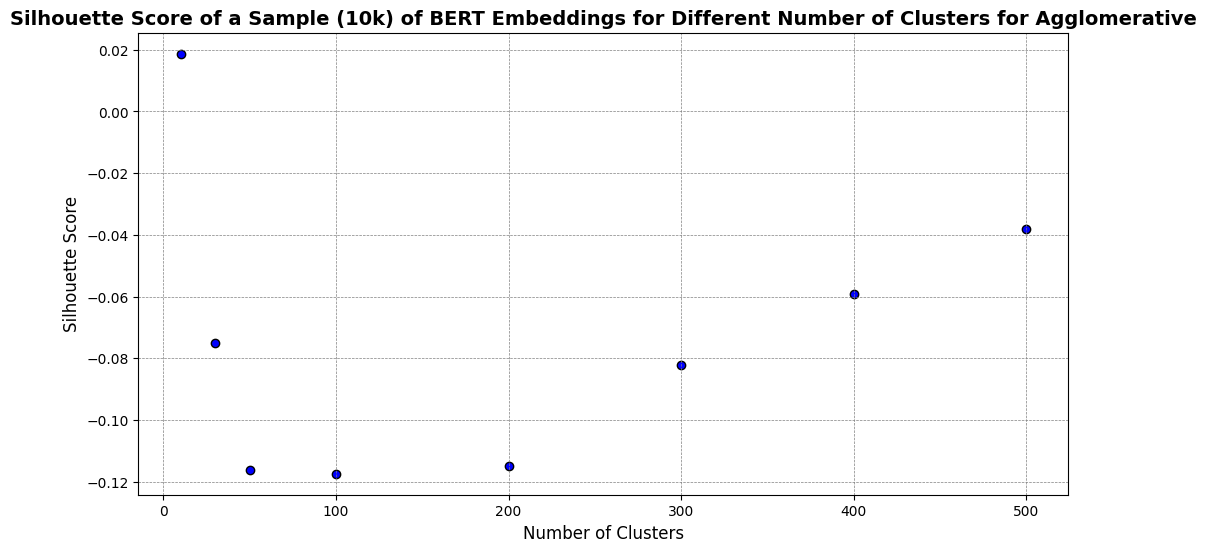

In [5]:
from sklearn.metrics import silhouette_score
import tqdm
random_indices=np.random.randint(0,len(all_tokens),1000)

subset_tokens=[all_tokens[i] for i in random_indices]
subset_embeddings=word_embeddings[random_indices,]
similarity_matrix = cosine_similarity(subset_embeddings)

def compute_silhouette_score(X, labels):
    return silhouette_score(X, labels)
# Apply K-means clustering
silh=list()
n_clusters_desired = [10,30,50,100,200,300,400,500]
for n in tqdm.tqdm(n_clusters_desired):
    cluster_agglomerative = AgglomerativeClustering(affinity='euclidean',n_clusters=n ,linkage='ward')
    cluster_agglomerative.fit(subset_embeddings)
    labels_agglomerative = cluster_agglomerative.fit_predict(subset_embeddings)
    silh.append(compute_silhouette_score(similarity_matrix,cluster_agglomerative.labels_))

# Create the figure and set the size
plt.figure(figsize=(12, 6))

# Create the scatter plot
plt.scatter(n_clusters_desired, silh, c='blue', marker='o', edgecolors='black', linewidths=1)

# Add title and labels with font customization
plt.title('Silhouette Score of a Sample (10k) of BERT Embeddings for Different Number of Clusters for Agglomerative', fontsize=14, fontweight='bold')
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)

# Add grid for better readability of the plot
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Optionally, you can add text annotations or other customizations here

# Show the plot
plt.show()

**Cluster stability**

In [ ]:
from sklearn.utils import resample
from sklearn.metrics import adjusted_rand_score
import numpy as np

def compute_cluster_stability(model, X, n_iterations=10):
    base_labels = model.fit_predict(X)
    stability_scores = []

    for i in range(n_iterations):
        X_resampled = resample(X)
        new_labels = model.fit_predict(X_resampled)
        
        # Compute the Adjusted Rand Index for stability
        stability = adjusted_rand_score(base_labels, new_labels)
        stability_scores.append(stability)
        
    return np.mean(stability_scores)




In [ ]:
n_clusters_desired = 50
random_indices=np.random.randint(0,len(all_tokens),1000)
subset_tokens=[all_tokens[i] for i in random_indices]
subset_embeddings=word_embeddings[random_indices,]
similarity_matrix = cosine_similarity(subset_embeddings)
kmeans = KMeans(n_clusters=n_clusters_desired, random_state=0)
labels_kmeans = kmeans.fit_predict(subset_embeddings)
stability_score = compute_cluster_stability(kmeans, similarity_matrix)
print("Cluster Stability Score:", stability_score)

**Modularity**

In [ ]:
import networkx as nx

def compute_modularity(G, communities):
    return nx.algorithms.community.modularity(G, communities)

In [ ]:
compute_modularity(G, communities)

**Normalized Gap**

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.datasets import make_blobs
import scipy.spatial

# Generate synthetic data for demonstration
X, y = make_blobs(n_samples=500, centers=4, random_state=42)

def compute_inertia(X, labels):
    inertia = 0
    for center in np.unique(labels):
        mask = labels == center
        inertia += scipy.spatial.distance.cdist(X[mask], X[mask]).sum()
    return inertia

def compute_gap_statistic(X, n_clusters, n_iterations=10):
    # Step 1: Run clustering on actual data
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    actual_inertia = compute_inertia(X, kmeans.labels_)
    
    # Step 2: Generate random datasets and compute their inertias
    random_inertias = []
    for i in range(n_iterations):
        random_data = np.random.random_sample(size=X.shape)
        kmeans.fit(random_data)
        random_inertia = compute_inertia(random_data, kmeans.labels_)
        random_inertias.append(random_inertia)
        
    expected_inertia = np.mean(random_inertias)
    sd_inertia = np.std(random_inertias)
    
    # Step 3: Compute the Gap statistic
    gap = np.log(expected_inertia) - np.log(actual_inertia)
    normalized_gap = gap / sd_inertia
    
    return normalized_gap

# Example
n_clusters = 4
normalized_gap = compute_gap_statistic(X, n_clusters)
print(f"Normalized Gap statistic: {normalized_gap}")


**Eigenvalue Gap**

In [ ]:
import numpy as np

def compute_eigenvalue_gap(Laplacian):
    eigenvalues = np.linalg.eigvals(Laplacian)
    eigenvalues = np.sort(eigenvalues)
    gaps = eigenvalues[1:] - eigenvalues[:-1]
    return np.argmax(gaps)

### Jaccard vs Cosine

- Eliminar los tokens que son demasiado cortos (minimo 4 letras)
- Cada fila cojer los tokens con una distancia de edicion minima de {1,2,3,4,..,max(min edit distance)}
- Calcular la distancia coseno de cada fila para cada distancia
- Hacer lo propio para todas las filas 
- Crear un plot con n histogramas donde n es la maxima min edit distance overall

In [ ]:
from Levenshtein import distance
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from collections import defaultdict
import tqdm

filtered_tokens=[token for token in all_tokens if len(token)>3]
filtered_embeddings=[word_embeddings[i] for i in range(len(word_embeddings)) if len(all_tokens[i])>3]

# Compute pairwise minimum edit distance
def compute_pairwise_distances(tokens):
    n = len(tokens)
    dist_matrix = np.zeros((n, n))
    
    for i in tqdm.tqdm(range(n)):
        for j in range(i+1, n):
            dist = distance(tokens[i], tokens[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
            
    return dist_matrix

# Precompute cosine similarities
def precompute_cosine_similarity(embeddings):
    return cosine_similarity(embeddings)

# Group distances and compute average cosine similarity
def group_and_average(embeddings, dist_matrix, precomputed_cosine_similarity):
    n = len(embeddings)
    results = {}
    
    for i in tqdm.tqdm(range(n)):
        distance_groups = defaultdict(list)
        
        for j in range(n):
            if i != j:  # Skip self-comparison
                dist = dist_matrix[i, j]
                cos_sim = precomputed_cosine_similarity[i, j]
                distance_groups[dist].append(cos_sim)
                
        average_similarities = {k: np.mean(v) for k, v in distance_groups.items()}
        results[i] = average_similarities
        
    return results

# Compute pairwise minimum edit distances
dist_matrix = compute_pairwise_distances(filtered_tokens)

# Precompute cosine similarities
precomputed_cosine_similarity = precompute_cosine_similarity(filtered_embeddings)

# Group by minimum edit distance and average cosine similarities
average_similarities_per_row = group_and_average(filtered_embeddings, dist_matrix, precomputed_cosine_similarity)





In [ ]:
import matplotlib.pyplot as plt
def create_boxplots(average_similarities_per_row):
    unique_distances = set()

    # Get all unique minimum edit distances
    for _, avg_sims in average_similarities_per_row.items():
        unique_distances.update(avg_sims.keys())
        
    unique_distances = sorted(list(unique_distances))

    # Prepare data for each unique distance
    boxplot_data = []

    for dist in unique_distances:
        values = []
        
        for _, avg_sims in average_similarities_per_row.items():
            if dist in avg_sims:
                values.append(avg_sims[dist])
                
        boxplot_data.append(values)

    # Create the boxplot
    plt.figure(figsize=(12, 6))
    plt.boxplot(boxplot_data, labels=[str(dist) for dist in unique_distances])
    plt.title('Average Cosine Similarities for Different Min Edit Distances')
    plt.xlabel('Min Edit Distance')
    plt.ylabel('Average Cosine Similarity')
    plt.show()

# Call the function to create boxplots
create_boxplots(average_similarities_per_row)



In [ ]:
import pandas as pd

# Convert average_similarities_per_row to DataFrame
# This is a dummy code snippet; you may have to adapt it to your data structure
df_list = []
for i, avg_sim in average_similarities_per_row.items():
    for dist, sim in avg_sim.items():
        df_list.append({'Min Edit Distance': dist, 'Average Cosine Similarity': sim})
df = pd.DataFrame(df_list)

# Now try plotting
import seaborn as sns
sns.violinplot(x='Min Edit Distance', y='Average Cosine Similarity', data=df)
